# IMDB-dataset learning with data cartography guided curriculum learning

## Section 0: Notebook setup

### 0.1: Imports

In [1]:
### Utility
import os
from pathlib import Path
import urllib

### Datascience
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

### Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Nltk download
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 0.2: Configuration setup

In [2]:
# Set of constant used, you can choose which to use below
SEEDS = [42, 69, 420, 42069, 69420]
CARD_DICT = {"sentence":"sentence-transformers/bert-base-nli-mean-tokens",
             "tiny":"prajjwal1/bert-tiny"
            }

In [3]:
# Constant setting --- you can change these
SEED_IDX = 0
CARD_KEY = "tiny"
MAX_LEN = 256
TRAIN_BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 2e-4

In [4]:
# Constant derivation settings --- DO NOT TOUCH
SEED = SEEDS[SEED_IDX]
CARD = CARD_DICT.get(CARD_KEY, "prajjwal1/bert-tiny")
torch.manual_seed(SEED)
np.random.seed(SEED);

### 0.3 Utility functions

#### 0.3.1 Dataset class definition

In [5]:
class Email_Dataset(Dataset):
    def __init__(self, df, tokenizer, labels, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[labels].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'index': index,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

#### 0.3.2: Model functions

##### Trainer function definition

In [6]:
def trainer(model, device, optimizer, loss_fn, loader, epochs, train_dyn={}, c_old:int=0, c_max:int=0, loss_lim:float=.0):
    counter = max(c_old, 0)
    losses = []
    results = {}
    for epoch in range(epochs):
        model.train()
        print(f'EPOCH {epoch + 1}/{epochs}...')
        for _,data in enumerate(loader):
            counter += 1
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids).logits

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if (float(loss.item()) < loss_lim) or counter == c_max:
                break
        # Evaluation done on train dataset for data cartography purposes
        print('Data Cartography sample generation...')
        model.eval()
        with torch.no_grad():
            for _, data in enumerate(loader):
                index = data['index']
                ids = data['ids'].to(device, dtype=torch.long)
                mask = data['mask'].to(device, dtype=torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
                targets = data['targets'].to(device, dtype=torch.float)

                outputs = model(ids, mask, token_type_ids).logits
                index = index.cpu().detach().numpy()
                fin_targets = targets.cpu().detach().numpy()
                fin_outputs = outputs.cpu().detach().numpy()

                for i in range(len(index)):
                  results[index[i]] = {'prob':fin_outputs[i], 'corr':fin_targets[i]}
        compute_prob_spam(results,train_dyn)
        if (float(loss.item()) < loss_lim) or counter == c_max:
            break
    return losses, counter

##### Evaluation function definition

In [7]:
def evaluation_run(model, loader, device):
    results = []
    for _, data in enumerate(loader):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

        outputs = model(ids, mask, token_type_ids).logits
        fin_outputs = torch.round(torch.nn.Softmax(dim=-1)(outputs)).cpu().detach().numpy()

        results.extend(fin_outputs)
    return results

#### 0.3.3 Plotting functions

In [8]:
def plot_data_map(dataframe: pd.DataFrame,
                  plot_dir: os.path,
                  hue_metric: str = 'correct.',
                  title: str = 'SPAM-det-cart',
                  model: str = 'BERT-tiny',
                  show_hist: bool = False,
                  max_instances_to_plot = 55000):
    # Set style.
    sns.set(style='whitegrid', font_scale=1.6, context='paper')


    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))

    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]

    main_metric = 'variability'
    other_metric = 'confidence'

    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    #num_hues=4
    hue_order = sorted(set(dataframe[hue].unique().tolist()))
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
    else:
        fig = plt.figure(figsize=(14, 10), )
        gs = fig.add_gridspec(3, 2, width_ratios=[5, 1])
        ax0 = fig.add_subplot(gs[:, 0])

    # Make the scatterplot.
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30,
                           hue_order=hue_order)

    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    func_annotate = lambda  text, xyc, bbc : ax0.annotate(text,
                                                          xy=xyc,
                                                          xycoords="axes fraction",
                                                          fontsize=15,
                                                          color='black',
                                                          va="center",
                                                          ha="center",
                                                          rotation=350,
                                                           bbox=bb(bbc))
    an1 = func_annotate("ambiguous", xyc=(0.9, 0.5), bbc='black')
    an2 = func_annotate("easy-to-learn", xyc=(0.27, 0.85), bbc='r')
    an3 = func_annotate("hard-to-learn", xyc=(0.35, 0.25), bbc='b')


    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=[0.175, 0.5], loc='right')
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')

    if show_hist:
        plot.set_title(f"{title}-{model} Data Map", fontsize=17)

        # Make the histograms.
        ax1 = fig.add_subplot(gs[0, 1])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[2, 1])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')
        plott1[0].set_ylabel('density')

        plot2 = sns.countplot(x="correct.", data=dataframe, ax=ax3, color='#86bf91')
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('density')

    fig.tight_layout()
    filename = f'{plot_dir}/{title}_{model}.pdf'# if show_hist else f'figures/compact_{title}_{model}.pdf'
    fig.savefig(filename, dpi=300)

In [9]:
def annotate(df):
  df2=df.copy()
  for i in range(len(df)):
    if df2.iloc[i]['confidence']>0.6 and df2.iloc[i]['variability']<0.15:
      df2.loc[i,'ann']='easy'
    elif df2.iloc[i]['confidence']<0.5 and df2.iloc[i]['variability']<0.15:
      df2.loc[i,'ann']='hard'
    else:
      df2.loc[i,'ann']='ambigous'
  return df2

In [10]:
def hard_to_learn(df,labels,threshold=0.25):
  diz={i:0 for i in labels}  #-> return the percentage of hard to learn sample per class
  for i in range(len(df)):
    if df.iloc[i]['c*(1-v)']<threshold:
      for k in labels:
        if df.iloc[i][k]==1:
          diz[k]+=1
  for j in labels:
    diz[j] /= df[j].sum()

  plt.bar(diz.keys(),diz.values(),color='blue')

# Add labels and title
  plt.xlabel('Class')
  plt.ylabel('Value')
  plt.title('Percentage of Hard To Learn')

#### 0.3.4 Data cartography functions

In [11]:
def check(A,B):
  for a,b in zip(A,B):
    if a!=b:
      return False
  return True

In [12]:
def compute_prob_spam(results,train_dyn):
    for i,logits in zip(results.keys(),results.values()):
        probs = torch.nn.functional.softmax(torch.Tensor(logits['prob']), dim=-1).numpy()
        true_class=np.argmax(logits['corr']) #to have probabilities from outputs
        true_class_prob =(probs[true_class])  #the probability of having the right class
        prediction = np.argmax(probs)  #argmax to obtain the predicted class
        is_correct = (prediction == true_class).item() #test if the class is the right one
        if i in train_dyn.keys():

            train_dyn[i]['prob'].append(true_class_prob)
            train_dyn[i]['corr'].append(is_correct)
        else:
            train_dyn[i]={}
            train_dyn[i]['prob']=[true_class_prob]
            train_dyn[i]['corr']=[is_correct]

In [13]:
def compute_metrics(train_dyn):
    confidence={}
    variability={}
    correctness={}
    variability_func = lambda conf: np.std(conf)
    for i in (train_dyn.keys()):
        correctness[i] = sum(train_dyn[i]['corr'])
        confidence[i] = np.mean(train_dyn[i]['prob'])  #by definition
        variability[i] = variability_func(train_dyn[i]['prob'])
    column_names = ['index',
                    'confidence',
                    'variability',
                    'correctness',
                  ]
    df=pd.DataFrame([[i,
                        confidence[i],
                        variability[i],
                        correctness[i],
                        ] for i in train_dyn.keys()], columns=column_names)

    return df.set_index('index')

## Section 1: Dataset import

In [14]:
!pip install -q kaggle

In [15]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [16]:
## Reset environment
!rm -rf ./spam-dataset

In [17]:
!kaggle datasets download -d 'yashpaloswal/spamham-email-classification-nlp'
!mkdir ./spam-dataset
!unzip -jq '/content/spamham-email-classification-nlp.zip' -d ./spam-dataset/

Dataset URL: https://www.kaggle.com/datasets/yashpaloswal/spamham-email-classification-nlp
License(s): DbCL-1.0
spamham-email-classification-nlp.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
df = pd.read_csv("./spam-dataset/emails.csv", index_col = False)

In [19]:
labels = df.Spam.unique().astype(str)
one_hot = pd.get_dummies(df.Spam).astype(float)
one_hot.rename(columns={0:'0',1:'1'},inplace=True)
df.drop(columns=['Spam'], inplace=True)
df = df.join(one_hot)
train, test = train_test_split(df, test_size=0.9)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [20]:
train.head()

,index,Text,0,1
0,1191,Subject: i was on your xango web site hello x...,0.0,1.0
1,1542,Subject: interview with the enron corp . resea...,1.0,0.0
2,3301,Subject: invitees for grant ' s party vince :...,1.0,0.0
3,3324,Subject: my new info dear friends and colleag...,1.0,0.0
4,2539,Subject: re : telephone interview with the enr...,1.0,0.0


In [21]:
test.head()

,index,Text,0,1
0,4445,Subject: re : energy derivatives conference - ...,1.0,0.0
1,4118,"Subject: financial maths course , part 2 vinc...",1.0,0.0
2,3893,Subject: re : bullet points please respond to...,1.0,0.0
3,4210,"Subject: re : enron default swaps darrell , ...",1.0,0.0
4,5603,"Subject: re : power question steve , elena c...",1.0,0.0


## Section 2: Baseline model generation

### 2.1: Tokenizer declaration

In [22]:
tokenizer = AutoTokenizer.from_pretrained(CARD)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### 2.2: Model definition

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model.bert.embeddings.parameters():
    param.requires_grad = False
for param in model.bert.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer.zero_grad()
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.3: Model instantiation

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

### 2.3: train and test loader creation

In [25]:
train_set = Email_Dataset(train, tokenizer, labels=labels, max_len=MAX_LEN)
loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)
test_set = Email_Dataset(test, tokenizer, labels=labels, max_len=MAX_LEN)
test_loader = DataLoader(test_set, batch_size=TRAIN_BATCH_SIZE, shuffle=False, pin_memory=True)

## Section 3: Training and validation

### 3.1: Training

In [26]:
train_dyn = {}
history, train_steps = trainer(model, device, optimizer, loss_fn, loader, EPOCHS*3, train_dyn)

EPOCH 1/60...
Data Cartography sample generation...
EPOCH 2/60...
Data Cartography sample generation...
EPOCH 3/60...
Data Cartography sample generation...
EPOCH 4/60...
Data Cartography sample generation...
EPOCH 5/60...
Data Cartography sample generation...
EPOCH 6/60...
Data Cartography sample generation...
EPOCH 7/60...
Data Cartography sample generation...
EPOCH 8/60...
Data Cartography sample generation...
EPOCH 9/60...
Data Cartography sample generation...
EPOCH 10/60...
Data Cartography sample generation...
EPOCH 11/60...
Data Cartography sample generation...
EPOCH 12/60...
Data Cartography sample generation...
EPOCH 13/60...
Data Cartography sample generation...
EPOCH 14/60...
Data Cartography sample generation...
EPOCH 15/60...
Data Cartography sample generation...
EPOCH 16/60...
Data Cartography sample generation...
EPOCH 17/60...
Data Cartography sample generation...
EPOCH 18/60...
Data Cartography sample generation...
EPOCH 19/60...
Data Cartography sample generation...
EP

### 3.2: Train loss plotting

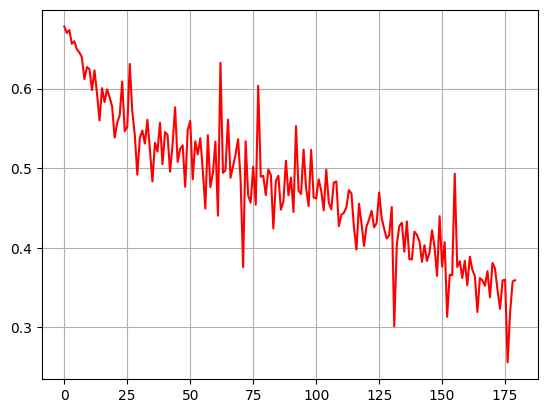

In [27]:
plt.plot(history, c='r')
plt.grid(True)
plt.show();

### 3.3: Model Validation

In [28]:
model.eval()
results = evaluation_run(model, test_loader, device)
results = pd.DataFrame(results, columns=labels)
print(classification_report(test[labels], results, zero_division=0.0, target_names = labels))

              precision    recall  f1-score   support

           1       0.92      0.35      0.51      1240
           0       0.83      0.99      0.90      3916

   micro avg       0.84      0.84      0.84      5156
   macro avg       0.88      0.67      0.71      5156
weighted avg       0.85      0.84      0.81      5156
 samples avg       0.84      0.84      0.84      5156



## Section 4: Data Cartography

### 4.1: Cartography computation

In [29]:
cartography = compute_metrics(train_dyn)
train = train.join(cartography)
new_col = pd.DataFrame(train['confidence'] * (1 - train['variability']), columns = ['c*(1-v)'])
premises = train.join(new_col)

### 4.2: Cartography plotting

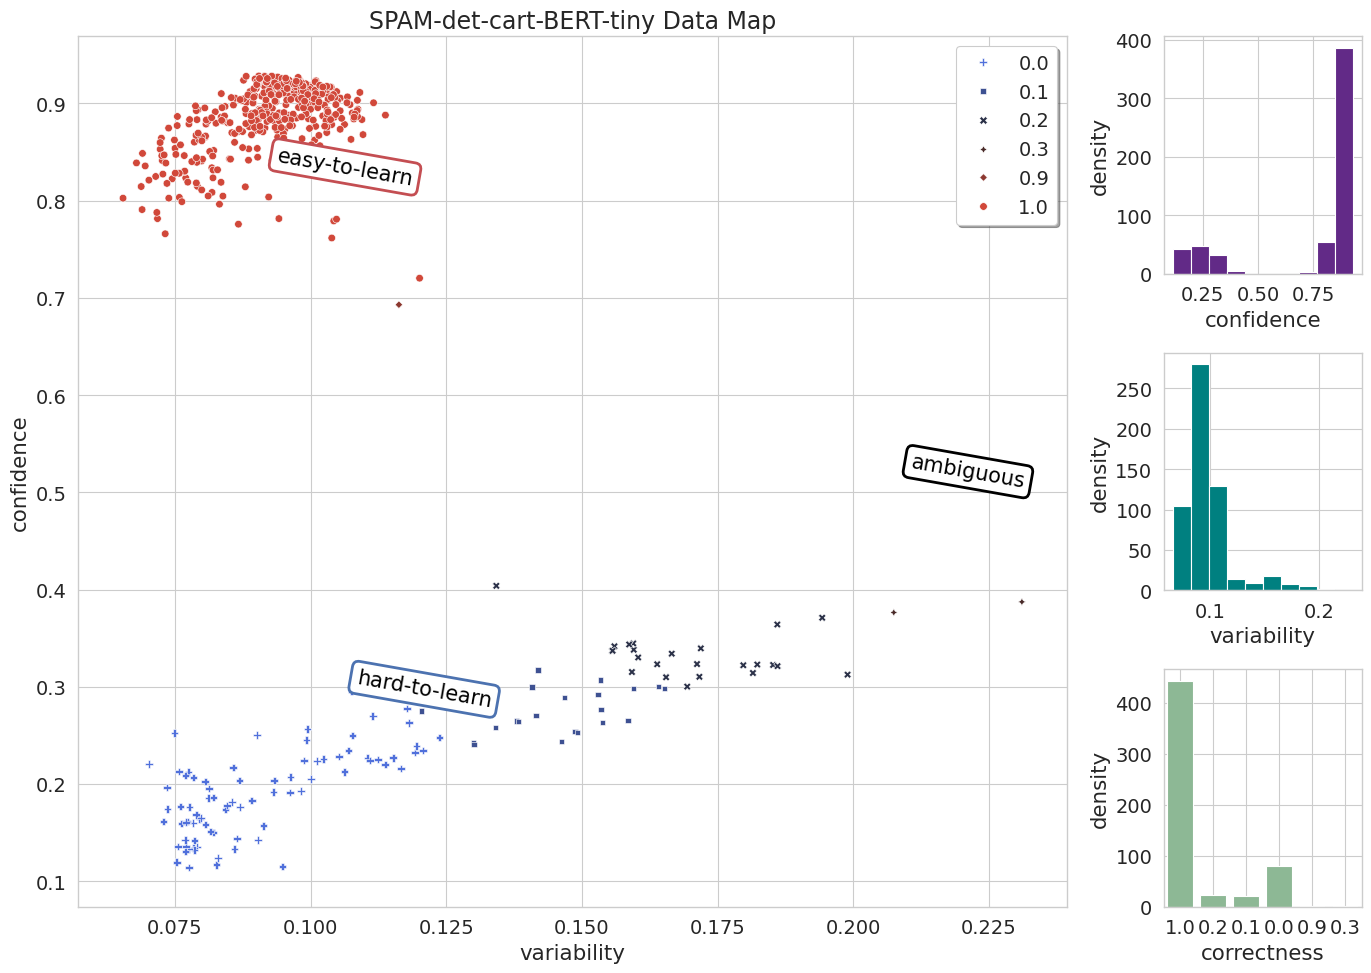

In [30]:
plot_data_map(cartography,plot_dir=os.getcwd(),show_hist=True)

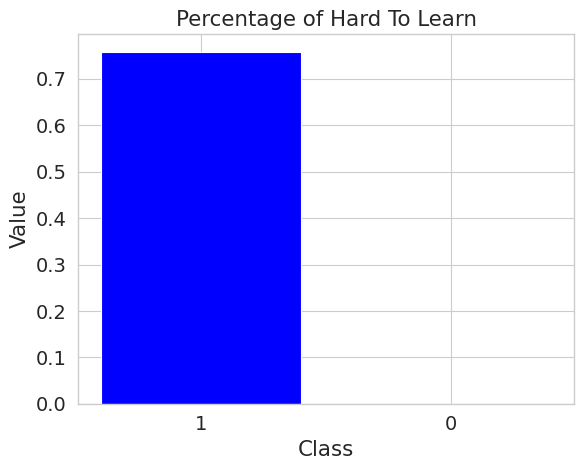

In [31]:
hard_to_learn(premises, labels)

## Section 5: Data Cartography guided model generation

### 5.1: Model definition

In [32]:
model2 = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model2.bert.embeddings.parameters(): # We don't want to train the first layer
    param.requires_grad = False
for param in model2.bert.encoder.parameters():
    param.requires_grad = False
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer2.zero_grad()
loss_fn2 = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.2: Model instantiation

In [33]:
device2 = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model2.to(device2)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

### 5.3: Creation of data cartography guided curriculum learning datasets

In [34]:
### Class based curriculum

datasets_curriculum = []
for i in [7, 5, 3, 2, 1, 0]:
  df = pd.DataFrame()
  for label in labels:
    dataset_temp = premises[premises[label] == 1.0]
    dataset_temp = dataset_temp[dataset_temp['c*(1-v)'] >= dataset_temp['c*(1-v)'].quantile(i/10)]
    df = pd.concat([df, dataset_temp], ignore_index=True)
  datasets_curriculum.append(df)

datasets_curriculum = [Email_Dataset(ds, tokenizer, labels, max_len=MAX_LEN) for ds in datasets_curriculum]
loaders_curriculum = [DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True) for ds in datasets_curriculum]

## Section 6: Curriculum learning training and validation

### 6.1: Model training

In [35]:
history2 = []
train_dyn2 = {}
c_old = 0
c_max = train_steps
loss_lim = [0.6, 0.45, 0.4, 0.35, 0.3, 0.03]
for i in range(len(loaders_curriculum)):
  his, c_old = trainer(model2, device2, optimizer2, loss_fn2, loaders_curriculum[i], (EPOCHS - len(loaders_curriculum) + i + 1)*2, train_dyn2, c_old, c_max, loss_lim[i])
  history2.extend(his)
  if c_old == c_max:
    break

EPOCH 1/30...
Data Cartography sample generation...
EPOCH 2/30...
Data Cartography sample generation...
EPOCH 3/30...
Data Cartography sample generation...
EPOCH 4/30...
Data Cartography sample generation...
EPOCH 5/30...
Data Cartography sample generation...
EPOCH 6/30...
Data Cartography sample generation...
EPOCH 7/30...
Data Cartography sample generation...
EPOCH 8/30...
Data Cartography sample generation...
EPOCH 9/30...
Data Cartography sample generation...
EPOCH 10/30...
Data Cartography sample generation...
EPOCH 11/30...
Data Cartography sample generation...
EPOCH 12/30...
Data Cartography sample generation...
EPOCH 13/30...
Data Cartography sample generation...
EPOCH 14/30...
Data Cartography sample generation...
EPOCH 15/30...
Data Cartography sample generation...
EPOCH 16/30...
Data Cartography sample generation...
EPOCH 17/30...
Data Cartography sample generation...
EPOCH 1/32...
Data Cartography sample generation...
EPOCH 2/32...
Data Cartography sample generation...
EPOC

### 6.2: Train loss plotting

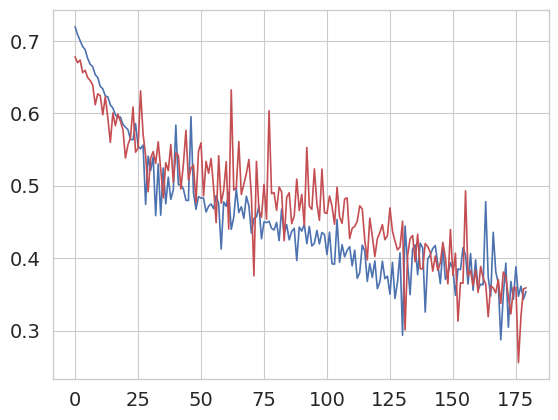

In [36]:
plt.plot(history2, c='b')
plt.plot(history, c='r')
plt.grid(True)
plt.show();

### 6.3: Model evaluation

In [37]:
model2.eval()
results2 = evaluation_run(model2, test_loader, device)
results2 = pd.DataFrame(results2, columns=labels)
print(classification_report(test[labels], results2, zero_division=0.0, target_names = labels))

              precision    recall  f1-score   support

           1       0.88      0.48      0.62      1240
           0       0.86      0.98      0.91      3916

   micro avg       0.86      0.86      0.86      5156
   macro avg       0.87      0.73      0.77      5156
weighted avg       0.86      0.86      0.84      5156
 samples avg       0.86      0.86      0.86      5156



#### Baseline model evaluation for comparison

In [38]:
print(classification_report(test[labels], results, zero_division=0.0, target_names = labels))

              precision    recall  f1-score   support

           1       0.92      0.35      0.51      1240
           0       0.83      0.99      0.90      3916

   micro avg       0.84      0.84      0.84      5156
   macro avg       0.88      0.67      0.71      5156
weighted avg       0.85      0.84      0.81      5156
 samples avg       0.84      0.84      0.84      5156

